# Hand Printed Names Recognition

## Overview

Recognizing hand printed text has been a challenge for Optical Character Recognition (OCR) because of handwritten texts’ many variations. With the rise of machine learning and higher processing power, however, modern OCR technology is now better at recognizing more subtle patterns in text, and, thus, although not perfect, better at recognizing hand handwritten text.

The ability to automate the process of converting handwriting text to machine-encoded text with the aid of machine learning has a lot of potential as a business application. The U.S. LIbrary of Congress, for example, holds approximately sixty million manuscripts, which are documents written by hand rather than typed or printed. Improving handwritten text recognition using machine learning can be of tremendous help with improving searchability, readability and accessibility of these documents, many of which are of historical significance.

## Approach
In this project I will demonstrate how to convert images of handwritten names into machine-encoded text using machine learning and computer vision techniques. Three major steps were taken to accomplish this task:

1. Import images of [Handwritten Characters dataset](https://www.kaggle.com/vaibhao/handwritten-characters) and generate datasets.
2. Create models to predict on validation set of Handwritten Characters dataset.
3. Perform character segmentation on the [Handwritten Names dataset](https://www.kaggle.com/landlord/handwriting-recognition), predict on identified characters, append predictions to a list to form a complete name prediction.

***
<h2 align="center">Library and Data Import</h2> 

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import random 
import cv2
import imutils
import random
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.models import Model, Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dense,MaxPooling2D, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.applications.resnet50 import ResNet50
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, f1_score

import pickle
import itertools

np.random.seed(123)

Using TensorFlow backend.


In [2]:
# Check if GPU is available
import sys

import tensorflow.keras
import sklearn as sk

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.1.0
Keras Version: 2.2.4-tf

Python 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
Pandas 1.2.1
Scikit-Learn 0.24.1
GPU is available


In [3]:
# Handwritten Characters dataset training and validation sets directories
train_dir = 'dataset/handwritten_character/Train'
val_dir = 'dataset/handwritten_character/Validation'

# set scale 
idg = ImageDataGenerator(rescale=1./255)

# get all the data in the directory train (834036 images), and reshape them
train_generator = idg.flow_from_directory(train_dir, color_mode = 'grayscale',
                                         target_size=(32, 32),
                                         batch_size = 834036,
                                         class_mode ='binary')

# get all the data in the directory validation (22524 images), and reshape them
valid_generator = idg.flow_from_directory(val_dir, color_mode = 'grayscale',
                                         target_size=(32, 32),
                                         batch_size = 22524,
                                         class_mode ='binary')

# create the data sets
# train_images, train_labels = next(train_generator)
# val_images, val_labels = next(valid_generator)

Found 834036 images belonging to 39 classes.
Found 22524 images belonging to 39 classes.


In [4]:
# Saving the train images/labels
save_path = "pickle_files/"

# with open(os.path.join(save_path, "train.pkl"), "wb") as f:
#     pickle.dump((train_images, train_labels), f)

In [5]:
# Saving the val images/labels

# with open(os.path.join(save_path, "val.pkl"), "wb") as f:
#     pickle.dump((val_images, val_labels), f)

In [4]:
# Load train images/labels
save_path = "pickle_files/"
with open(os.path.join(save_path, "train.pkl"), "rb") as f:
    (train_images, train_labels) = pickle.load(f)

In [5]:
# Load val images/labels
save_path = "pickle_files/"
with open(os.path.join(save_path, "val.pkl"), "rb") as f:
    (val_images, val_labels) = pickle.load(f)

***
<h2 align="center">Exploratory Data Analysis </h2>

### Handwritten Characters dataset 

In [6]:
# Explore your dataset
print('Train images shape: ', train_images.shape)
print('Val images shape: ', val_images.shape)
print('Train labels shape: ', train_labels.shape)
print('Val labels shape: ', val_labels.shape)

Train images shape:  (834036, 32, 32, 1)
Val images shape:  (22524, 32, 32, 1)
Train labels shape:  (834036,)
Val labels shape:  (22524,)


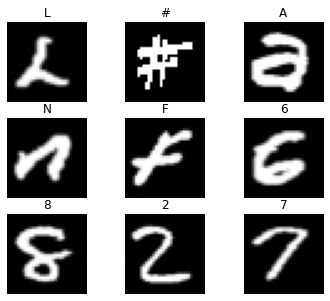

In [7]:
# plot samples of training images
for i in range(100, 109):
    plt.subplot(330 + (i+1))
    plt.imshow(array_to_img(train_images[i]), cmap=plt.get_cmap('gray'))
    plt.title(str([k for k, v in train_generator.class_indices.items() if v == train_labels[i]][0]))
    plt.axis('off')
    plt.subplots_adjust(top=1.4)

### Handwritten Names dataset

In [59]:
#read in names dataset dataframe to check frequency of names
names_train = pd.read_csv('dataset/handwritting_names/written_name_train_v2.csv')

In [60]:
names_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330961 entries, 0 to 330960
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   FILENAME  330961 non-null  object
 1   IDENTITY  330396 non-null  object
dtypes: object(2)
memory usage: 5.1+ MB


In [22]:
# preview dataframe
names_train.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [23]:
# Top 20 most commonly appearing names in the training set
names_train.IDENTITY.value_counts().head(20)

THOMAS       1825
EMPTY        1796
LEA          1582
EMMA         1482
LUCAS        1479
CAMILLE      1367
HUGO         1367
CLEMENT      1313
MANON        1277
LOUIS        1257
THEO         1214
CHLOE        1204
ANTOINE      1168
MARIE        1156
ENZO         1148
CLARA        1143
PAUL         1118
NATHAN       1107
ALEXANDRE    1080
MAXIME       1066
Name: IDENTITY, dtype: int64

***
<h2 align="center"> Datasets Preparation for Modeling </h2>

In [12]:

LB = LabelBinarizer()
train_labels = LB.fit_transform(train_labels)
val_labels = LB.fit_transform(val_labels)

In [13]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

In [18]:
train_img_unrow = train_images.reshape(834036, -1)
val_img_unrow = val_images.reshape(22524, -1)
train_labels_final = train_labels.reshape(834036, -1)
val_labels_final = val_labels.reshape(22524, -1)

In [19]:
np.shape(train_labels_final)

(834036, 39)

In [20]:
np.shape(val_labels_final)

(22524, 39)

***
<h2 align="center"> Modeling </h2>

### K Nearest Neighbors

In [8]:
# Load model from file
save_path = "saved_models/"

with open(os.path.join(save_path, "KNN_model.pkl"), "rb") as f:
    kNN_model = pickle.load(f)

### Convolutinal Neural Networks

In [9]:
# Load model

model_2 = keras.models.load_model('saved_models/CNN_model_2')

In [10]:
# Load model

model_3 = keras.models.load_model('saved_models/CNN_model_3')

### Models Performace Comparison

In [22]:
model_1_scor = kNN_model.score(val_img_unrow, val_labels_final)
model_2_scor = model_2.evaluate(val_images, val_labels)
model_3_scor = model_3.evaluate(val_images, val_labels)


22524/22524 [==============================] - 3s 137us/step


In [23]:
model_1_scor

0.9355354288758657

In [29]:
print('KNN model accuracy score: ', model_1_scor*100)
print('CNN model 1 accuracy score: ', model_2_scor[1]*100)
print('CNN model 2 accuracy score: ', model_3_scor[1]*100)

KNN model accuracy score:  93.55354288758657
CNN model 1 accuracy score:  96.73681259155273
CNN model 2 accuracy score:  97.18522429466248


In [30]:
print('CNN model 1 loss: ', model_2_scor[0])
print('CNN model 2 loss: ', model_3_scor[0])

CNN model 1 loss:  0.09472487168771115
CNN model 2 loss:  0.08640751707019265


### Performance Comparisons between CNNS

In [43]:
cm_plot_labels= list(train_generator.class_indices.keys())

In [44]:
predictions_1 = model_2.predict(x=val_images, verbose=0)
predictions_2 = model_3.predict(x=val_images, verbose=0)

In [45]:
cm_1 = confusion_matrix(y_true=LB.inverse_transform(val_labels), y_pred=np.argmax(predictions_1, axis=1))
cm_2 = confusion_matrix(y_true=LB.inverse_transform(val_labels), y_pred=np.argmax(predictions_2, axis=1))

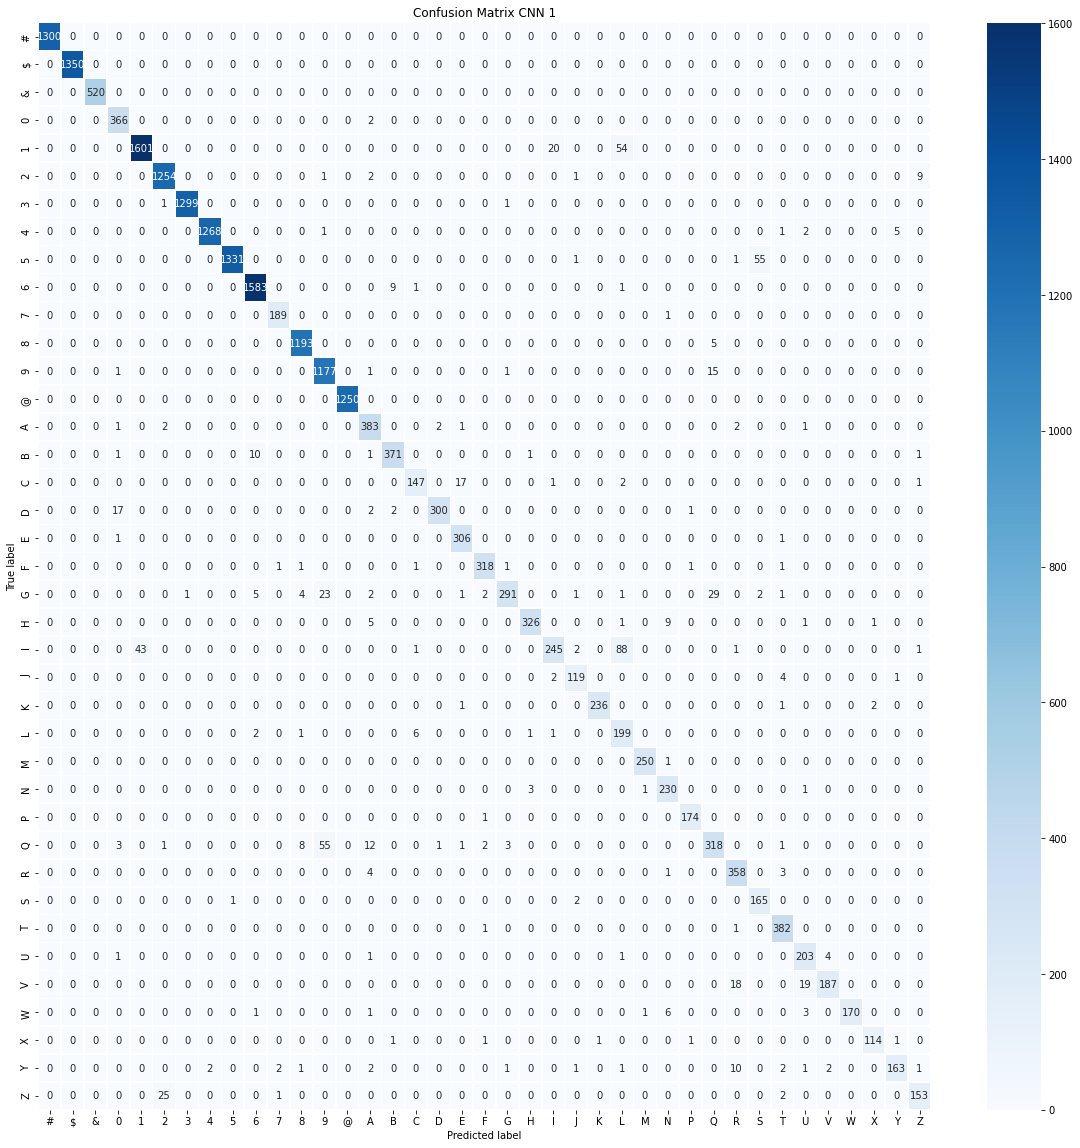

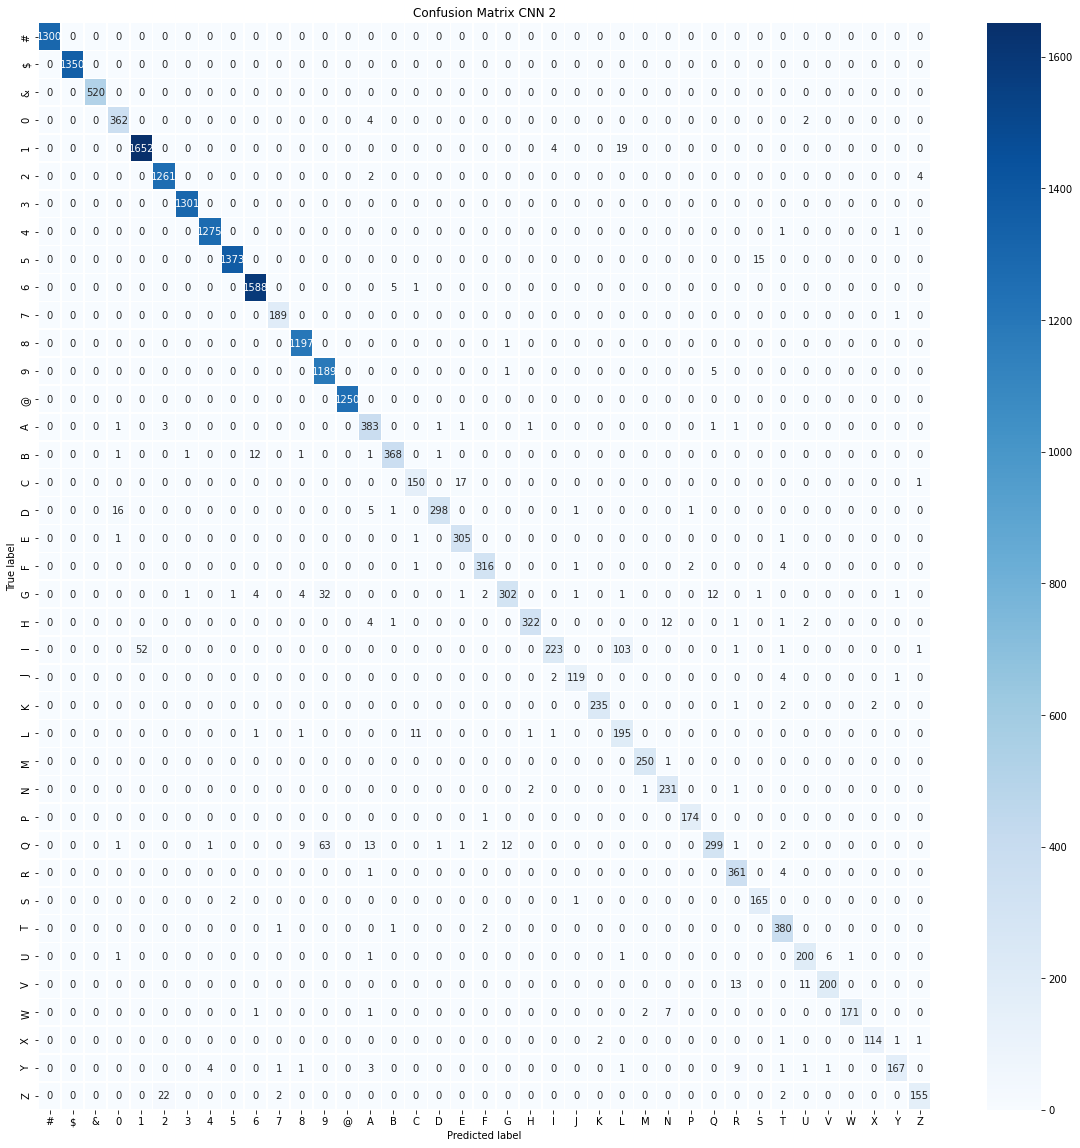

In [46]:
CNN_1 = plt.figure(figsize=(20,20))
CNN_1 = sns.heatmap(cm_1, xticklabels=cm_plot_labels, yticklabels=cm_plot_labels, annot=True, fmt='d', cmap='Blues', linewidths=.5)
CNN_1.set(xlabel='Predicted label', ylabel='True label', title='Confusion Matrix CNN 1')


CNN_2 = plt.figure(figsize=(20,20))
CNN_2 = sns.heatmap(cm_2, xticklabels=cm_plot_labels, yticklabels=cm_plot_labels, annot=True, fmt='d', cmap='Blues', linewidths=.5)
CNN_2.set(xlabel='Predicted label', ylabel='True label', title='Confusion Matrix CNN 2')

plt.show()

In [29]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

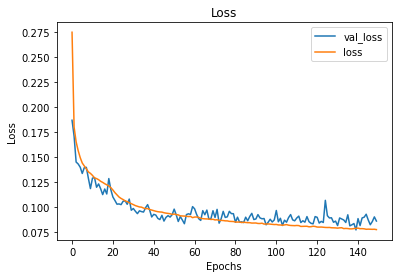

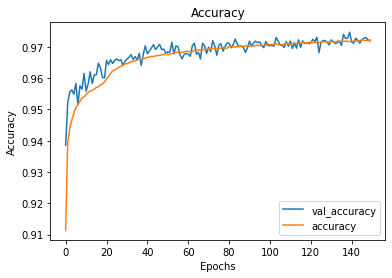

In [30]:
visualize_training_results(results_3)

In [31]:
# Save model

# model_3.save('saved_models/CNN_model_3')

In [32]:
from keras import models
from keras.preprocessing import image

(1, 32, 32, 1)


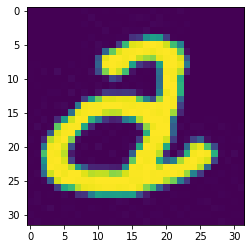

In [33]:
img_path = "dataset/handwritten_character/Train/A/_1_47.jpg"

img = image.load_img(img_path, target_size=(32, 32), color_mode='grayscale')
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

img_tensor /= 255.

print(img_tensor.shape)

plt.imshow(img_tensor[0])
plt.show()

In [34]:
# Extract model layer outputs
layer_outputs = [layer.output for layer in model_3.layers[:8]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=model_3.input, outputs=layer_outputs)

(1, 30, 30, 32)


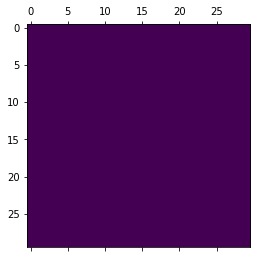

In [35]:
#returns an array for each activation layer
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

# We slice the third channel and preview the results
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')

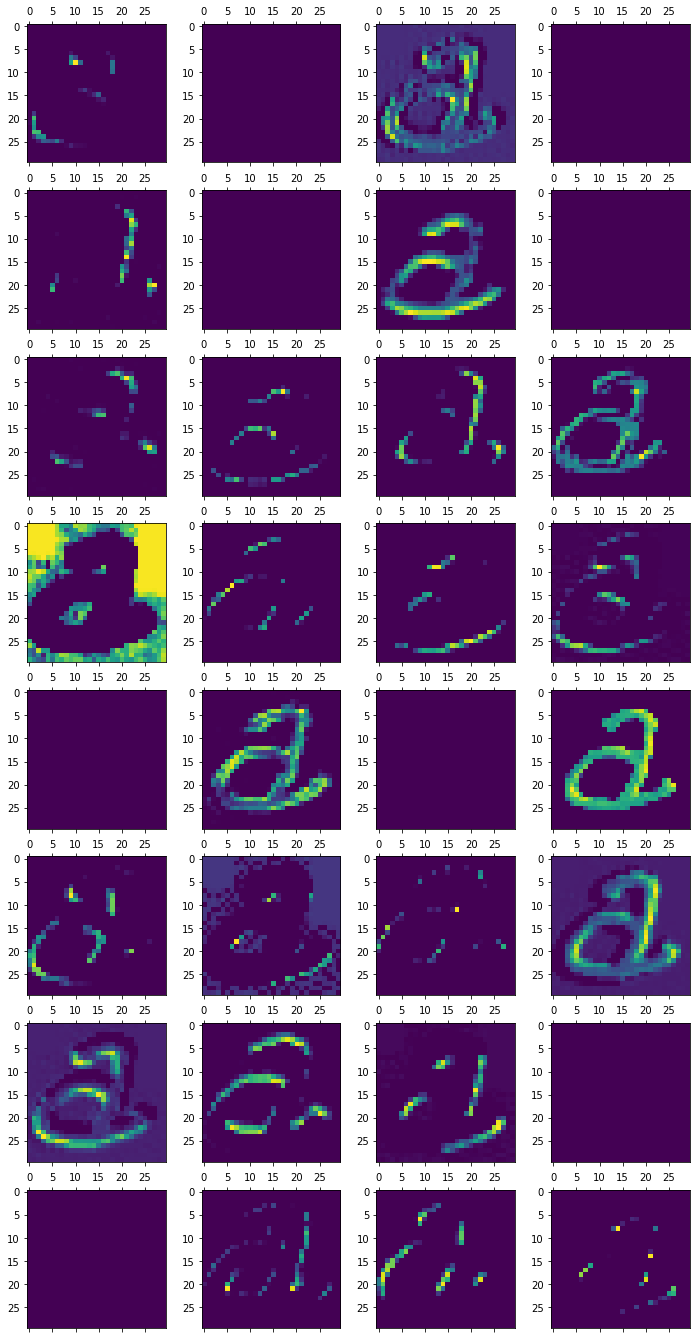

In [36]:
# visualize all 32 of these channels from the first activation function

fig, axes = plt.subplots(8, 4, figsize=(12, 24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

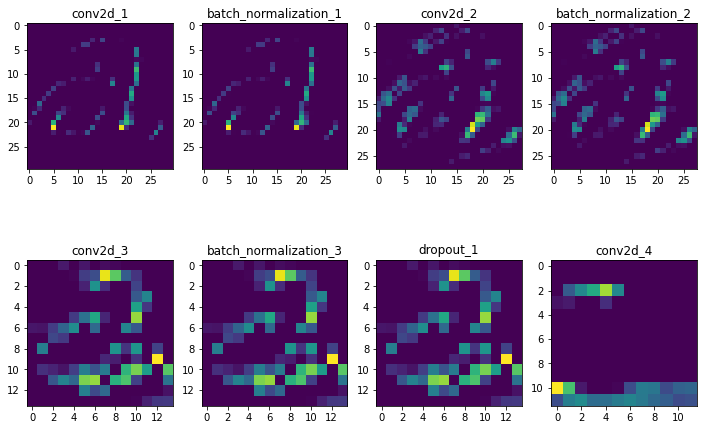

In [37]:
# visualization of the 29th channel for each of the activation layers

fig, axes = plt.subplots(2, 4, figsize=(12, 8))

layer_names = []
for layer in model_3.layers[:8]:
    layer_names.append(layer.name)
    
for i in range(8):
    row = i//4
    column = i%4
    ax = axes[row, column]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :, 29], cmap='viridis')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])

In [118]:
np.argmax(predictions, axis=1)

array([11, 29, 25, ...,  6, 21, 13], dtype=int64)

In [120]:
val_labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [121]:
LB.inverse_transform(val_labels)

array([11., 29., 25., ...,  6., 21., 13.], dtype=float32)

In [153]:
import plotly.express as px

In [155]:
# px.imshow(cm, x=cm_plot_labels, y=cm_plot_labels)

In [24]:
# Are there names that are lower case?

In [25]:
# turn this into a top 20 names list

In [57]:
names_train[names_train.IDENTITY == 'THOMAS'].head(10)

,FILENAME,IDENTITY
26,TRAIN_00027.jpg,THOMAS
84,TRAIN_00085.jpg,THOMAS
166,TRAIN_00167.jpg,THOMAS
250,TRAIN_00251.jpg,THOMAS
898,TRAIN_00899.jpg,THOMAS
1395,TRAIN_01396.jpg,THOMAS
1443,TRAIN_01444.jpg,THOMAS
1621,TRAIN_01622.jpg,THOMAS
1862,TRAIN_01863.jpg,THOMAS
1975,TRAIN_01976.jpg,THOMAS


In [30]:
def sort_contours(cnts, method='left-to-right'):
    reverse = False
    i = 0
    if method == 'right-to-left' or method == 'bottom-to-top':
        reverse = True
    if method == 'top-to-bottom' or method == 'botton-to-top':
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
       key = lambda b:b[1][i], reverse=reverse))
    return (cnts, boundingBoxes)

In [31]:
def get_letters(img):
    letters = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    # loop over the contours
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 255), 2)
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (32, 32), interpolation = cv2.INTER_CUBIC)
        thresh = thresh.astype("float32") / 255.0
        thresh = np.expand_dims(thresh, axis=-1)
        thresh = thresh.reshape(1,32,32,1)
        ypred = model_3.predict(thresh)
        ypred = LB.inverse_transform(ypred)
        ypred = [k for k, v in train_generator.class_indices.items() if v == ypred]
        [x] = ypred
        letters.append(x)
    return letters, image

In [42]:
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [43]:
# ret,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV)

In [44]:
# dilated = cv2.dilate(thresh1, None, iterations=2)

In [45]:
# cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

In [46]:
# cnts = imutils.grab_contours(cnts)

In [47]:
# cnts = sort_contours(cnts, method="left-to-right")[0]

In [48]:
# for c in cnts:
#         if cv2.contourArea(c) > 10:
#             (x, y, w, h) = cv2.boundingRect(c)
#             cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

In [49]:
# roi = gray[y:y + h, x:x + w]

In [50]:
# thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

In [51]:
# thresh = cv2.resize(thresh, (32, 32), interpolation = cv2.INTER_CUBIC)

In [52]:
# thresh = thresh.astype("float32") / 255.0

In [53]:
# thresh = np.expand_dims(thresh, axis=-1)

In [54]:
# thresh = thresh.reshape(1,32,32,1)

In [55]:
# ypred = model_1.predict(thresh)

In [56]:
# ypred = LB.inverse_transform(ypred)

In [57]:
# ypred

In [33]:
def get_word(letter):
    word = "".join(letter)
    return word

In [1]:
name = ['e', 'd', 'w', 'a', 'r', 'd']

In [2]:
name

['e', 'd', 'w', 'a', 'r', 'd']

In [4]:
"".join(name)

'edward'

CLARA


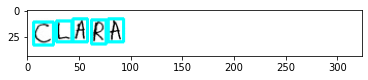

In [27]:
letter, image = get_letters("dataset/handwritting_names/train_v2/train/TRAIN_00411.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

In [39]:
letter

['J', '0', 'H', 'H']

JENNIFER


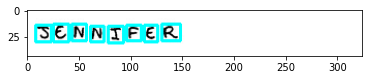

In [43]:
letter, image = get_letters("dataset/handwritting_names/train_v2/train/TRAIN_20375.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

MICHHEL


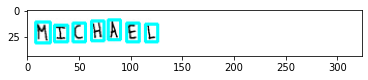

In [50]:
letter, image = get_letters("dataset/handwritting_names/train_v2/train/TRAIN_64874.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

E175A


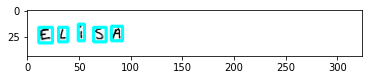

In [52]:
letter, image = get_letters("dataset/handwritting_names/train_v2/train/TRAIN_00037.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

6E0R6E


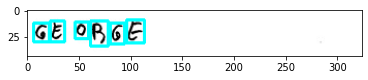

In [56]:
letter, image = get_letters("dataset/handwritting_names/train_v2/train/TRAIN_27599.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

TH0MA5


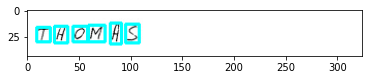

In [58]:
letter, image = get_letters("dataset/handwritting_names/train_v2/train/TRAIN_00027.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)